# Train classificacion model 

To perform the model train we use: *train_class.sh*, with the following code

chemprop_train \
    --data_path ../Data/pIC50_NRAS.csv \    
    --dataset_type classification \
    --save_dir test_checkpoints_class \
    --target_columns pIC50 \
    --features_generator rdkit_2d_normalized --no_features_scaling \
    --save_smiles_splits


- **pIC50_NRAS.csv** : Dataset with 653 compounds with inhibitory activity against NRAS classified according to pIC50.
- **--target_columns pIC50** : binary variable according to pIC50 (if pIC50 is greater than 7 it is classified with 1)
- **--features_generator rdkit_2d_normalized --no_features_scaling** : pre-normalized RDKit features
- **--save_smiles_splits** : By default, random split the data into 80% train, 10% validation, and 10% test. With these line we can save the three datasets used, to further study of the results obtained. The diferents dataset are stored in *'test_checkpoints_class/fold_0'* :

    - Train data : "train_full" (smiles + pIC50) / "train_smiles" (only smiles)
    - Validation data : "val_full" (smiles + pIC50) / "val_smiles" (only smiles)
    - Test data : "test_full" (smiles + pIC50) / "test_smiles" (only smiles)

The model is trained for 30 epochs.
The default metric for classification is AUC.

# Evaluate the model on test data.

Now that we have trained the model, the next step is to evaluate its performance on a test dataset (the split one).

With *train_pred_class.sh* :

chemprop_predict \
    --test_path test_checkpoints_class/fold_0/test_smiles.csv \
    --preds_path test_preds_class.csv \
    --checkpoint_dir test_checkpoints_class \
    --features_generator rdkit_2d_normalized --no_features_scaling

- **test_preds_class.csv** : predictions for the compounds in our test dataset

Moreover, in the following script we will compare the predicted values of our model against the real pIC50 classification. 

In [3]:
import pandas as pd
#load real pIC50 classification

df_true = pd.read_csv('test_checkpoints_class/fold_0/test_full.csv')
print(df_true.columns)

Index(['SMILES', 'pIC50'], dtype='object')


In [4]:
#load predicted values
df_preds = pd.read_csv('test_preds_class.csv')
print(df_preds.columns)

#column renaming to better manage data

df_preds.rename(columns={'pIC50': 'preds'}, inplace=True)
print(df_preds.columns)

Index(['SMILES', 'pIC50'], dtype='object')
Index(['SMILES', 'preds'], dtype='object')


In [5]:
#combination of the two data sets

df = df_true.merge(df_preds, on='SMILES', how='inner')
print(df)

                                               SMILES  pIC50     preds
0   CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...    1.0  0.713995
1   CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...    0.0  0.326059
2   CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...    1.0  0.872838
3   CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...    0.0  0.341301
4   CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...    1.0  0.778836
..                                                ...    ...       ...
61  CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...    1.0  0.717162
62  CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...    0.0  0.331802
63  CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...    1.0  0.795286
64  CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...    0.0  0.640524
65  CCn1c(c2CC(C)(C)COC(=O)[C@@H]3CCCN(N3)C(=O)[C@...    0.0  0.308809

[66 rows x 3 columns]


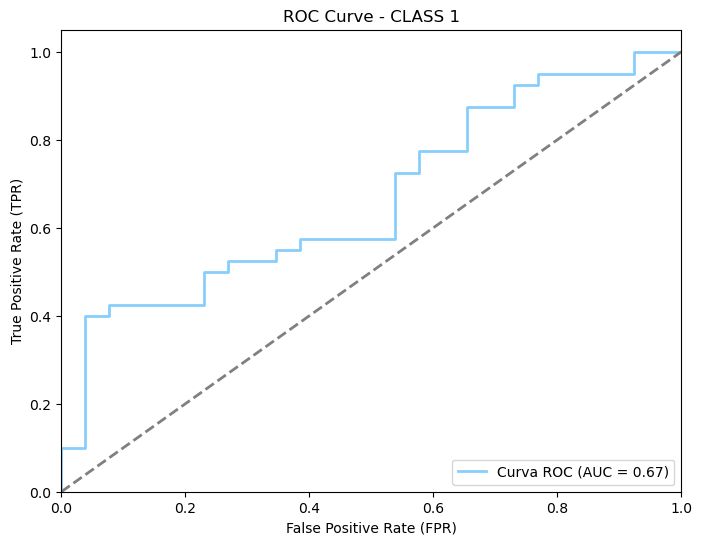

In [7]:
#ROC CURVE REPRESENTATION

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(df.pIC50, df.preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='lightskyblue', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - CLASS 1')
plt.legend(loc='lower right')
plt.show()

